This notebook collects NLU data (emotion and sentiment scores) for all the tweets collected by Twint. This code uses two Open Source Emotion Models and One Sentiment Model: 

https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

https://github.com/pysentimiento/pysentimiento

#Import Libraries

In [ ]:
!pip install pysentimiento
from pysentimiento import SentimentAnalyzer, EmotionAnalyzer
from transformers import pipeline
import glob
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from pysentimiento.preprocessing import preprocess_tweet

In [ ]:
# combining all twitter data files
path = 'data/'

os.chdir(path)


extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension)) if 'outlets' in i]
print(all_filenames)
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])

In [7]:
combined_csv

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,player,season,tweet_username,media_type
0,0,1107356066533249025,1107356066533249025,1.552849e+12,2019-03-17 19:00:34,0,NaN,The best record in The Association. All-Star ...,en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,7.0,19,https://twitter.com/ESPNNBA/status/11073560665...,[],[],1.0,https://pbs.twimg.com/ext_tw_video_thumb/11073...,False,279.0,6.0,51.0,NaN,Giannis Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Giannis Antetokounmpo,2018-2019,ESPNNBA,outlet
1,1,1101726972789440512,1101726972789440512,1.551507e+12,2019-03-02 06:12:34,0,NaN,The All-Star captains battled out in LA. @Gi...,en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,6.0,6,https://twitter.com/ESPNNBA/status/11017269727...,[],['https://pbs.twimg.com/media/D0oe17GX0AEHyL9....,1.0,https://pbs.twimg.com/media/D0oe17GX0AEHyL9.jpg,False,806.0,19.0,121.0,NaN,Giannis Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Giannis Antetokounmpo,2018-2019,ESPNNBA,outlet
2,2,1097312665481949184,1097312665481949184,1.550455e+12,2019-02-18 01:51:41,0,NaN,.@Giannis_An34 is currently out-dunking everyo...,en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,1.0,1,https://twitter.com/ESPNNBA/status/10973126654...,[],['https://pbs.twimg.com/media/DzpwDawWkAAHXlV....,1.0,https://pbs.twimg.com/media/DzpwDawWkAAHXlV.jpg,False,415.0,5.0,59.0,NaN,Giannis Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Giannis Antetokounmpo,2018-2019,ESPNNBA,outlet
3,3,1093361980130447360,1093361980130447360,1.549513e+12,2019-02-07 04:13:04,0,NaN,"""...I know I’m going to draft Steph Curry firs...",en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,4.0,4,https://twitter.com/ESPNNBA/status/10933619801...,[],[],1.0,https://pbs.twimg.com/ext_tw_video_thumb/10933...,False,2806.0,20.0,291.0,NaN,Giannis Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Giannis Antetokounmpo,2018-2019,ESPNNBA,outlet
4,4,1091884864431902720,1091884864431902720,1.549161e+12,2019-02-03 02:23:32,0,NaN,.@Giannis_An34 made the most FT without a miss...,en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,7.0,2,https://twitter.com/ESPNNBA/status/10918848644...,[],['https://pbs.twimg.com/media/Dycnf0-WoAMFPn_....,1.0,https://pbs.twimg.com/media/Dycnf0-WoAMFPn_.jpg,False,8490.0,50.0,1034.0,NaN,Giannis Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Giannis Antetokounmpo,2018-2019,ESPNNBA,outlet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0,1304243837,1304243837,1.236664e+12,2009-03-10 05:52:49,0,NaN,Fernandez leaves via stretcher: Brandon Roy sc...,en,[],[],14885860.0,14885860,CBSSports,CBS Sports,2.0,5,https://twitter.com/CBSSports/status/1304243837,[],[],0.0,NaN,False,0.0,0.0,0.0,NaN,Brandon Roy,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Brandon Roy,2008-2009,CBSSports,outlet
35,0,1251069029,1251069029,1.235599e+12,2009-02-25 21:59:36,0,NaN,San Antonio Spurs forward Tim Duncan to miss s...,en,[],[],2557521.0,2557521,espn,ESPN,3.0,21,https://twitter.com/espn/status/1251069029,[],[],0.0,NaN,False,0.0,0.0,0.0,NaN,Tim Duncan,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Tim Duncan,2008-2009,espn,outlet
36,0,1252533047,1252533047,1.235626e+12,2009-02-26 05:22:08,0,NaN,Parker carries S.A. again: With Tim Duncan sid...,en,[],[],14885860.0,14885860,CBSSports,CBS Sports,4.0,5,https://twitter.com/CBSSports/status/1252533047,[],[],0.0,NaN,False,0.0,0.0,0.0,NaN,Tim Duncan,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Tim Duncan,2008-2009,CBSSports,outlet
37,1,1251257789,1251257789,1.235602e+12,2009-02-25 22:49:03,0,NaN,Spurs' Duncan out again: Spurs forward Tim Dun...,en,

# Initializing NLU models

In [ ]:
sentiment_analyzer = SentimentAnalyzer(lang="en")
emotion_analyzer = EmotionAnalyzer(lang="en")
emotion_classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

# Compiling Data

In [ ]:
def get_emotion_scores(row):
  """
  Calulates emotion scores (two models) and sentiment scores for a single tweet.
  
  Parameters:
  row - a single pandas row from a df, should have 'tweet' column

  Return:
  A pandas row with NLU scores appended as new columns
  """

  # Extract the line as a string
  text = row['tweet']

  text = preprocess_tweet(text, lang= 'en').replace('url', "").strip()
  
  emotion_output = emotion_analyzer.predict(preprocess_tweet(text))
  emotion_output = emotion_output.probas

  sentiment_output = sentiment_analyzer.predict(preprocess_tweet(text))
  emotion_output_2 = emotion_classifier(text)

  # Loop through the scores in the results and add each score to the row
  for dictionary in emotion_output_2[0]:
    label = dictionary['label']
    label = 'distilbert ' + label
    score = dictionary['score']
    row[label] = score

  for emotion in emotion_output:
    label = emotion
    label = 'pysent ' + label
    score = emotion_output[emotion]
    row[label] = score
  
  row['pysent sentiment_label'] = sentiment_output.output
  for sent in sentiment_output.probas:
    label = sent
    label = 'pysent ' + label
    score = sentiment_output.probas[sent]
    row[label] = score
  return row

In [ ]:
nlu_data = combined_csv.apply(get_emotion_scores,axis=1)

In [ ]:
nlu_data

,Unnamed: 0,Unnamed: 0.1,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,player,season,tweet_username,media_type,distilbert sadness,distilbert joy,distilbert love,distilbert anger,distilbert fear,distilbert surprise,pysent others,pysent joy,pysent sadness,pysent anger,pysent surprise,pysent disgust,pysent fear,pysent sentiment_label,pysent NEG,pysent NEU,pysent POS
0,0,0,1388538811764944898,1388538811764944898,1.619888e+12,2021-05-01 17:00:25,0,NaN,".@Rachel__Nichols: ""Did you think you were dra...",en,[],[],2557521.0,2557521,espn,ESPN,6.0,17,https://twitter.com/espn/status/13885388117649...,[],[],1.0,https://pbs.twimg.com/media/E0UUsC0XMAA7T1H.png,False,5088.0,59.0,478.0,NaN,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Nikola Jokic,2020-2021,espn,outlet,0.241558,0.453959,0.004481,0.286253,0.012393,0.001356,0.973987,0.007699,0.001393,0.001313,0.002213,0.011625,0.001771,NEU,0.012976,0.633710,0.353314
1,1,1,1381698637156220929,1381698637156220929,1.618258e+12,2021-04-12 20:00:00,0,NaN,Nikola Jokic is the odds on favorite for NBA M...,en,[],[],2557521.0,2557521,espn,ESPN,1.0,20,https://twitter.com/espn/status/13816986371562...,['https://twitter.com/i/broadcasts/1mnxeaorLeL...,[],0.0,NaN,False,115.0,29.0,6.0,NaN,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Nikola Jokic,2020-2021,espn,outlet,0.001059,0.992715,0.001508,0.002931,0.001447,0.000340,0.970222,0.015978,0.000872,0.000992,0.006543,0.001964,0.003429,POS,0.001377,0.299672,0.698951
2,2,2,1357433749571465217,1357433749571465217,1.612472e+12,2021-02-04 21:00:00,0,NaN,"Thursday Bet. is here! Today, @JoeFortenbaugh ...",en,[],[],2557521.0,2557521,espn,ESPN,4.0,21,https://twitter.com/espn/status/13574337495714...,['https://twitter.com/i/broadcasts/1RDGlPoWamd...,[],0.0,NaN,False,62.0,2.0,12.0,NaN,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Nikola Jokic,2020-2021,espn,outlet,0.129369,0.223993,0.005095,0.629223,0.010689,0.001631,0.965179,0.022786,0.000832,0.001075,0.005523,0.001985,0.002620,NEU,0.009659,0.940524,0.049817
3,3,3,1355997844042342401,1355997844042342401,1.612130e+12,2021-01-31 21:54:13,0,NaN,Nikola Jokic dropped 33 points in the first ha...,en,[],[],2557521.0,2557521,espn,ESPN,7.0,21,https://twitter.com/espn/status/13559978440423...,[],['https://pbs.twimg.com/media/EtF42oqW8AAZTSn....,1.0,https://pbs.twimg.com/media/EtF42oqW8AAZTSn.jpg,False,8980.0,60.0,649.0,NaN,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Nikola Jokic,2020-2021,espn,outlet,0.416393,0.100281,0.007489,0.343021,0.125428,0.007388,0.798523,0.027314,0.007319,0.002087,0.155362,0.005364,0.004032,NEU,0.003824,0.947489,0.048687
4,4,0,1372375584546902019,1372375584546902019,1.616035e+12,2021-03-18 02:33:31,0,NaN,Nikola Jokic passes Dikembe Mutombo for the mo...,en,[],[],74518740.0,74518740,ESPNNBA,NBA on ESPN,4.0,2,https://twitter.com/ESPNNBA/status/13723755845...,[],['https://pbs.twimg.com/tweet_video_thumb/Ewuo...,1.0,https://pbs.twimg.com/tweet_video_thumb/EwuoT0...,False,1319.0,16.0,78.0,NaN,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,Nikola Jokic,2020-2021,ESPNNBA,outlet,0.018511,0.424333,0.006967,0.245896,0.290927,0.013366,0.949626,0.023682,0.001860,0.001324,0.018080,0.004004,0.001424,NEU,0.001997,0.825726,0.172277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,34,0,1304243837,1304243837,1.236664e+12,2009-03-10 05:52:49,0,NaN,Fernandez leaves via stretcher: Brandon Roy sc...,en,[],[],14885860.0,14885860,CBSSports,CBS Sports,2.0,5,https://twitter.com/CBSSports/status/1304243837,[],[],0.0,NaN,F

# Data Visualization



In [ ]:
nlu_data['Datetime'] = pd.to_datetime(nlu_data['date'])
nlu_data = nlu_data.set_index('Datetime')

In [ ]:
# isolating player, season, and nlu scores by week
weeks_avg=nlu_data[['player','season','distilbert sadness', 'distilbert joy',
                    'distilbert love', 'distilbert anger', 'distilbert fear',
                    'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
                    'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
                    'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()
weeks_avg

,distilbert sadness,distilbert joy,distilbert love,distilbert anger,distilbert fear,distilbert surprise,pysent others,pysent joy,pysent sadness,pysent anger,pysent surprise,pysent disgust,pysent fear,pysent NEG,pysent NEU,pysent POS
Datetime,,,,,,,,,,,,,,,,
2008-11-02,0.012662,0.883356,0.006736,0.071278,0.020342,0.005626,0.559542,0.425537,0.004066,0.004320,0.002372,0.002217,0.001946,0.001495,0.825276,0.173229
2008-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-23,0.222567,0.084421,0.004194,0.292692,0.392806,0.003321,0.915628,0.018911,0.010324,0.001448,0.005852,0.003186,0.044651,0.579337,0.414490,0.006173
2008-11-30,0.001426,0.483468,0.001158,0.508961,0.003780,0.001207,0.974651,0.011103,0.001245,0.001314,0.002920,0.006897,0.001870,0.182835,0.794892,0.022273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-25,0.063114,0.636669,0.027669,0.213644,0.053385,0.005519,0.750638,0.176920,0.002600,0.001782,0.026071,0.022082,0.019906,0.055442,0.582505,0.362053
2021-05-02,0.082693,0.474193,0.028489,0.318859,0.092435,0.003331,0.865984,0.028767,0.043821,0.001777,0.017446,0.038382,0.003822,0.047336,0.789575,0.163089
2021-05-09,0.052469,0.639452,0.003829,0.215397,0.054927,0.033926,0.727171,0.180152,0.004031,0.001571,0.049720,0.002988,0.034366,0.060278,0.608618,0.331104


Plotting Average Positive Sentiment by Week for Top 3 MVP Candidates 2020-2021

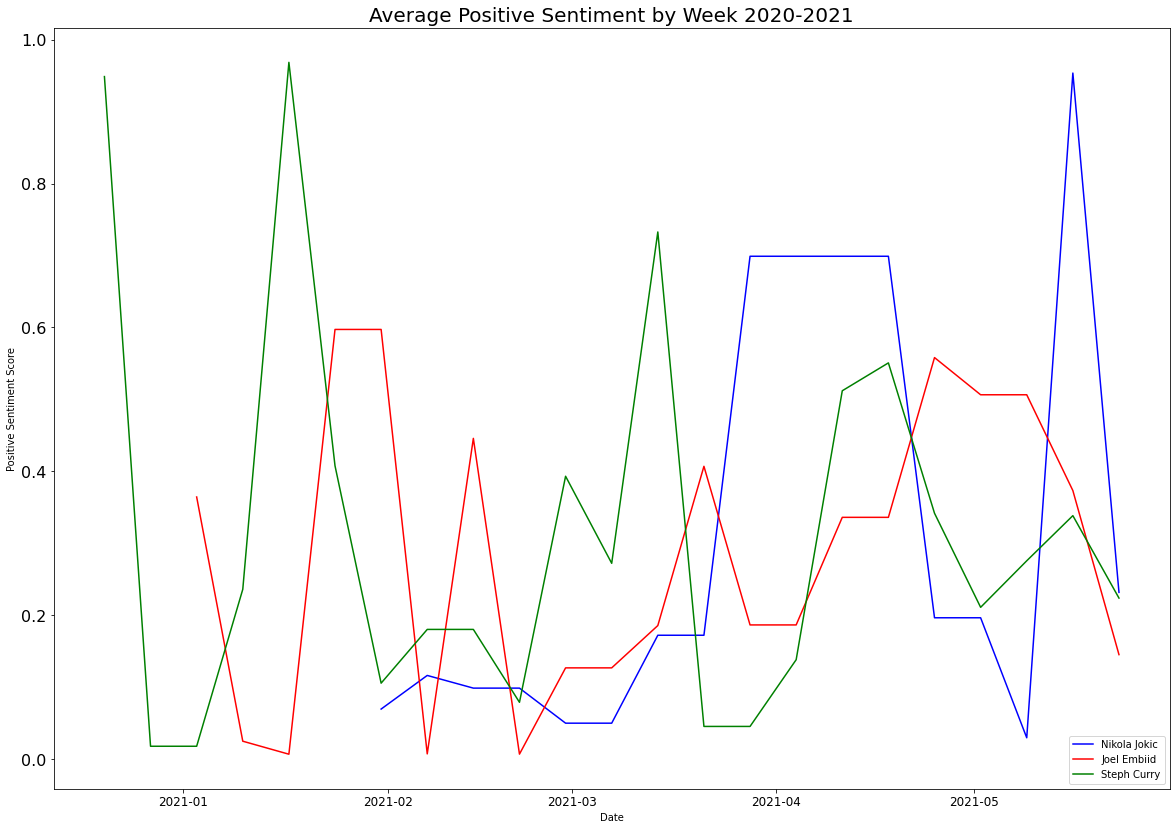

In [ ]:
plt.figure(figsize=(20,14))
weeks_avg=nlu_data.loc[(nlu_data['player'] == 'Nikola Jokic') & (nlu_data['season'] == '2020-2021')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()


plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'b-',label = "Nikola Jokic")

weeks_avg=nlu_data.loc[(nlu_data['player'] == 'Joel Embiid') & (nlu_data['season'] == '2020-2021')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()
plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'r-',label = 'Joel Embiid')

weeks_avg=nlu_data.loc[(nlu_data['player'] == 'Steph Curry') & (nlu_data['season'] == '2020-2021')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()
plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'g-',label = 'Steph Curry')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Score')
plt.legend()
plt.title('Average Positive Sentiment by Week 2020-2021', fontsize=20);
#plt.savefig('Positive Sentiment 2020-21.png')

Plotting Average Positive Sentiment by Week for Top 3 MVP Candidates 2019-2020

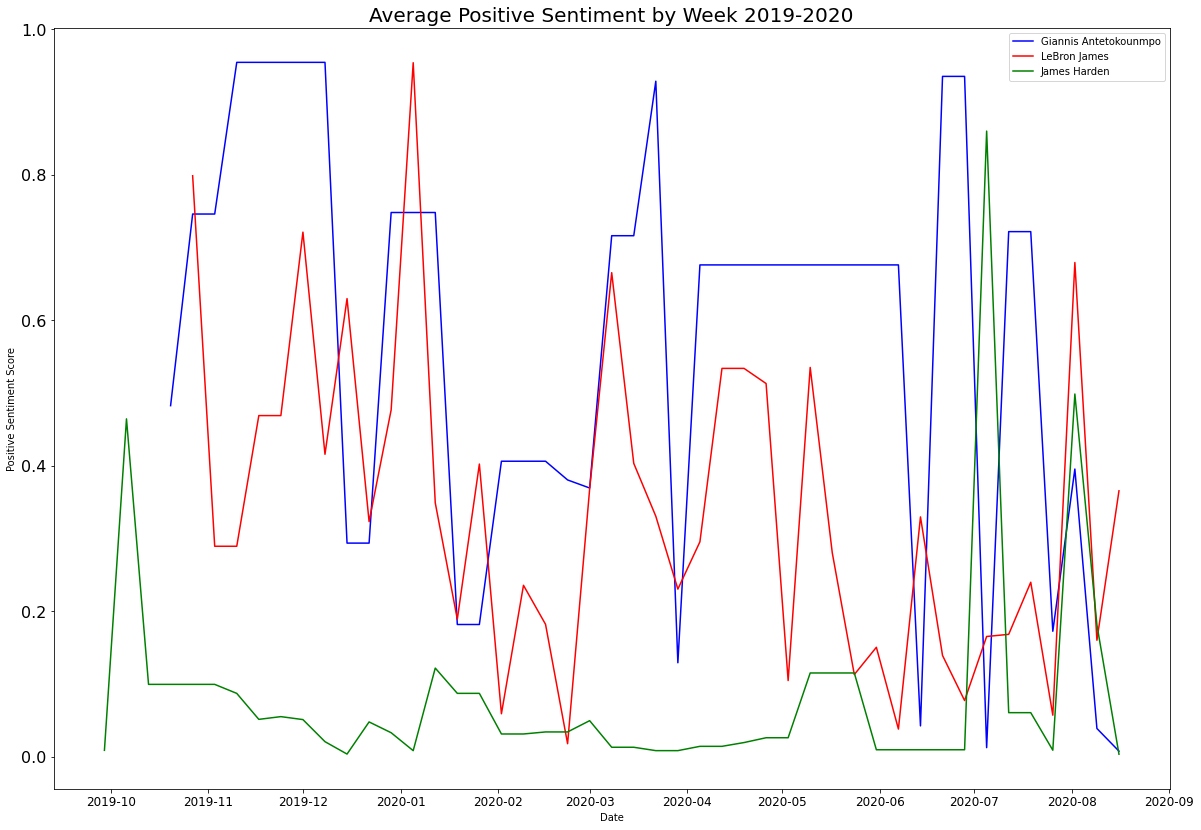

In [ ]:
plt.figure(figsize=(20,14))
weeks_avg=nlu_data.loc[(nlu_data['player'] == 'Giannis Antetokounmpo') & (nlu_data['season'] == '2019-2020')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()


plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'b-',label = "Giannis Antetokounmpo")

weeks_avg=nlu_data.loc[(nlu_data['player'] == 'LeBron James') & (nlu_data['season'] == '2019-2020')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()
plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'r-',label = 'LeBron James')

weeks_avg=nlu_data.loc[(nlu_data['player'] == 'James Harden') & (nlu_data['season'] == '2019-2020')][['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('W').mean()
plt.plot(weeks_avg['pysent POS'].fillna(method="bfill"),'g-',label = 'James Harden')
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Score')
plt.legend()
plt.title('Average Positive Sentiment by Week 2019-2020', fontsize=20);
plt.savefig('Positive Sentiment 2019-20.png')

In [ ]:
# isolating the MVP Winner and their respective season
df = nlu_data[nlu_data["season"].shift() != nlu_data["season"]]
mvpdict = df[['player','season']].to_dict('records')

In [ ]:
# Getting df of only MVP winners
mvp_nlu_only = nlu_data.loc[(nlu_data.player == mvpdict[0]['player']) & (nlu_data.season == mvpdict[0]['season'])]
for mvp in mvpdict[1:]:
 tempdf = nlu_data.loc[(nlu_data.player == mvp['player']) & (nlu_data.season == mvp['season'])]
 mvp_nlu_only = pd.concat([mvp_nlu_only,tempdf])

In [ ]:
# Getting df of Non-MVPs
nonmvp_nlu_only = nlu_data.loc[(nlu_data.player != mvpdict[0]['player']) & (nlu_data.season == mvpdict[0]['season'])]
for mvp in mvpdict[1:]:
 tempdf = nlu_data.loc[(nlu_data.player != mvp['player']) & (nlu_data.season == mvp['season'])]
 nonmvp_nlu_only = pd.concat([nonmvp_nlu_only,tempdf])

In [ ]:
# Getting scores by month for both player types
mvp_nlu_only['Datetime'] = pd.to_datetime(mvp_nlu_only['date'])
mvp_nlu_only = mvp_nlu_only.set_index('Datetime')

nonmvp_nlu_only['Datetime'] = pd.to_datetime(nonmvp_nlu_only['date'])
nonmvp_nlu_only = nonmvp_nlu_only.set_index('Datetime')

months_avg_mvp=mvp_nlu_only[['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('M').mean()
       
months_avg_nonmvp=nonmvp_nlu_only[['player','season','distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent sentiment_label', 'pysent NEG', 'pysent NEU', 'pysent POS']].resample('M').mean()


Plotting Emotion Scores for MVPs vs Non-MVPs

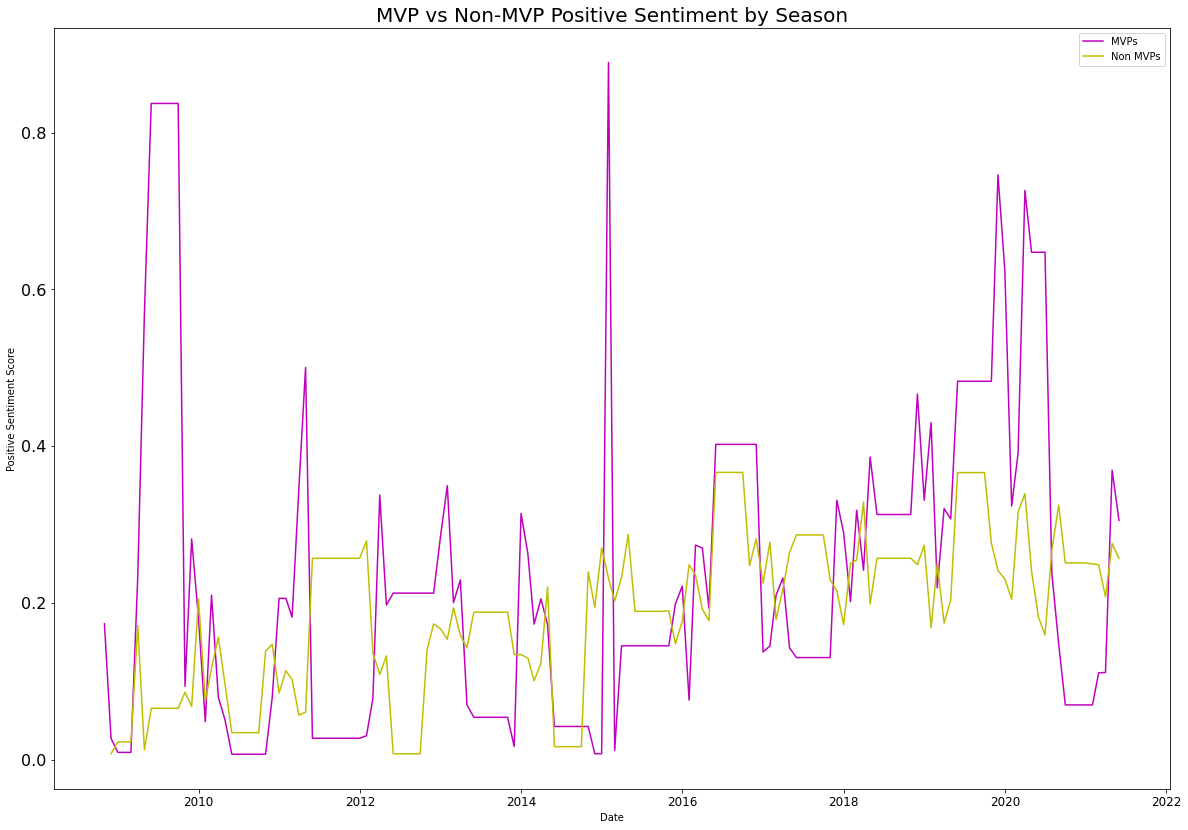

In [ ]:
plt.figure(figsize=(20,14))

plt.plot(months_avg_mvp['pysent POS'].fillna(method="bfill"),'m-',label = "MVPs")

plt.plot(months_avg_nonmvp['pysent POS'].fillna(method="bfill"),'y-',label = 'Non MVPs')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Score')
plt.legend()
plt.title('MVP vs Non-MVP Positive Sentiment by Season', fontsize=20);
plt.savefig('Positive Sentiment MVP vs Non All Seasons.png')

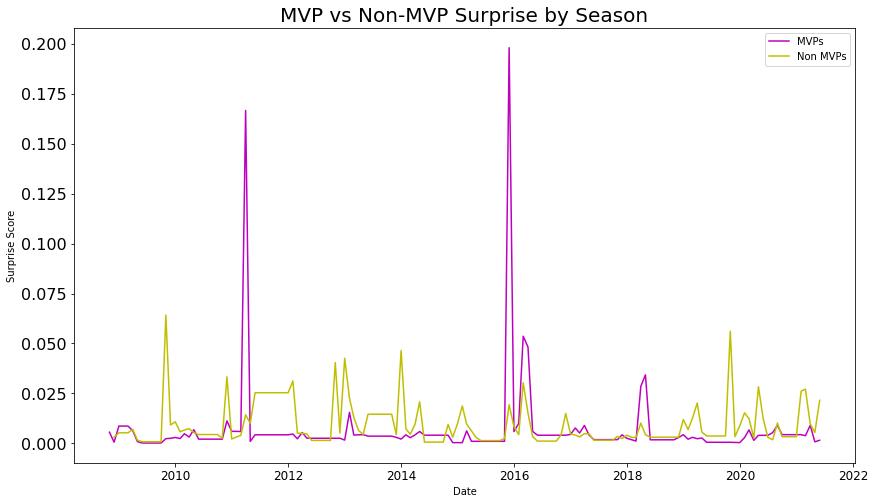

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(months_avg_mvp['distilbert surprise'].fillna(method="bfill"),'m-',label = "MVPs")

plt.plot(months_avg_nonmvp['distilbert surprise'].fillna(method="bfill"),'y-',label = 'Non MVPs')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Surprise Score')
plt.legend()
plt.title('MVP vs Non-MVP Surprise by Season', fontsize=20);
plt.savefig('Surprise MVP vs Non All Seasons.png')

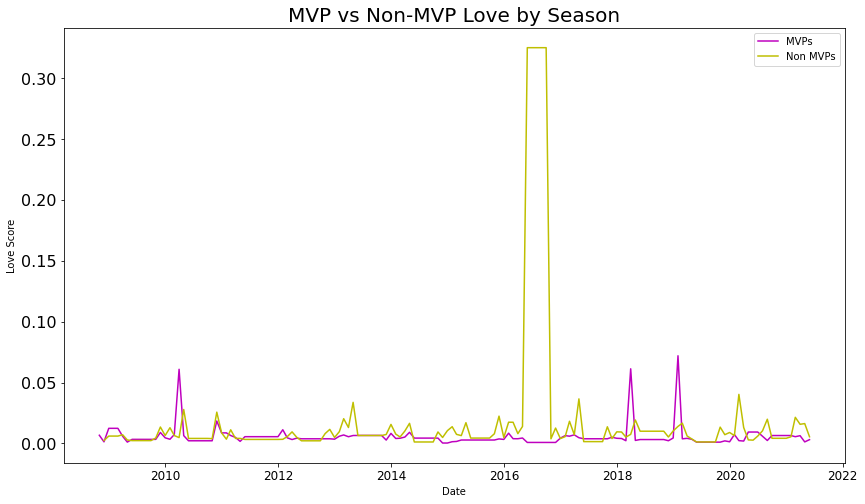

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(months_avg_mvp['distilbert love'].fillna(method="bfill"),'m-',label = "MVPs")

plt.plot(months_avg_nonmvp['distilbert love'].fillna(method="bfill"),'y-',label = 'Non MVPs')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Love Score')
plt.legend()
plt.title('MVP vs Non-MVP Love by Season', fontsize=20);
plt.savefig('Love MVP vs Non All Seasons.png')